In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import re
from collections import Counter
from google.colab import files

In [2]:
# Upload CSV file manually
uploaded = files.upload()

Saving poems-100.csv to poems-100.csv


In [3]:
# Read the CSV file
df = pd.read_csv("poems-100.csv")

# Extract only the poems content
poems = df['text'].dropna().tolist()

# Convert to lowercase and remove special characters
cleaned_poems = [re.sub(r"[^a-zA-Z\s]", "", poem.lower()) for poem in poems]


In [4]:
# Tokenization
all_words = [word for poem in cleaned_poems for word in poem.split()]
vocab = sorted(set(all_words))
vocab_size = len(vocab)
word_to_idx = {word: i for i, word in enumerate(vocab)}
idx_to_word = {i: word for word, i in word_to_idx.items()}


In [5]:
# One-hot encoding function
def one_hot_encode(word, vocab_size):
    vec = np.zeros(vocab_size)
    vec[word_to_idx[word]] = 1
    return vec

In [6]:
# Prepare dataset
seq_length = 2
input_data = []
target_data = []
for poem in cleaned_poems:
    words = poem.split()
    for i in range(len(words) - seq_length):
        input_data.append([one_hot_encode(words[j], vocab_size) for j in range(i, i+seq_length)])
        target_data.append(word_to_idx[words[i + seq_length]])

X = torch.tensor(input_data, dtype=torch.float32)
y = torch.tensor(target_data, dtype=torch.long)

<ipython-input-6-104322e34800>:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  X = torch.tensor(input_data, dtype=torch.float32)


In [7]:
# Define RNN Model
class RNNModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(vocab_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

In [8]:
# Initialize model
hidden_size = 16
model = RNNModel(vocab_size, hidden_size, vocab_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [16]:
# Training loop
epochs = 500
losses = []
accuracies = []

for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(X)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    # Compute accuracy
    _, predicted = torch.max(output, 1)
    accuracy = (predicted == y).float().mean().item()
    accuracies.append(accuracy)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')

Epoch 10/500, Loss: 3.7138, Accuracy: 0.3375
Epoch 20/500, Loss: 3.5547, Accuracy: 0.3604
Epoch 30/500, Loss: 3.4130, Accuracy: 0.3817
Epoch 40/500, Loss: 3.2870, Accuracy: 0.4004
Epoch 50/500, Loss: 3.1749, Accuracy: 0.4187
Epoch 60/500, Loss: 3.0752, Accuracy: 0.4357
Epoch 70/500, Loss: 2.9863, Accuracy: 0.4499
Epoch 80/500, Loss: 2.9070, Accuracy: 0.4604
Epoch 90/500, Loss: 2.8359, Accuracy: 0.4714
Epoch 100/500, Loss: 2.7719, Accuracy: 0.4809
Epoch 110/500, Loss: 2.7143, Accuracy: 0.4902
Epoch 120/500, Loss: 2.6623, Accuracy: 0.4965
Epoch 130/500, Loss: 2.6150, Accuracy: 0.5039
Epoch 140/500, Loss: 2.5717, Accuracy: 0.5093
Epoch 150/500, Loss: 2.5318, Accuracy: 0.5141
Epoch 160/500, Loss: 2.4950, Accuracy: 0.5195
Epoch 170/500, Loss: 2.4610, Accuracy: 0.5234
Epoch 180/500, Loss: 2.4295, Accuracy: 0.5270
Epoch 190/500, Loss: 2.4001, Accuracy: 0.5303
Epoch 200/500, Loss: 2.3727, Accuracy: 0.5340
Epoch 210/500, Loss: 2.3470, Accuracy: 0.5381
Epoch 220/500, Loss: 2.3230, Accuracy: 0.54

In [17]:
# Saving Model Weights
torch.save(model.state_dict(), "rnn_one_hot_weights.pth")

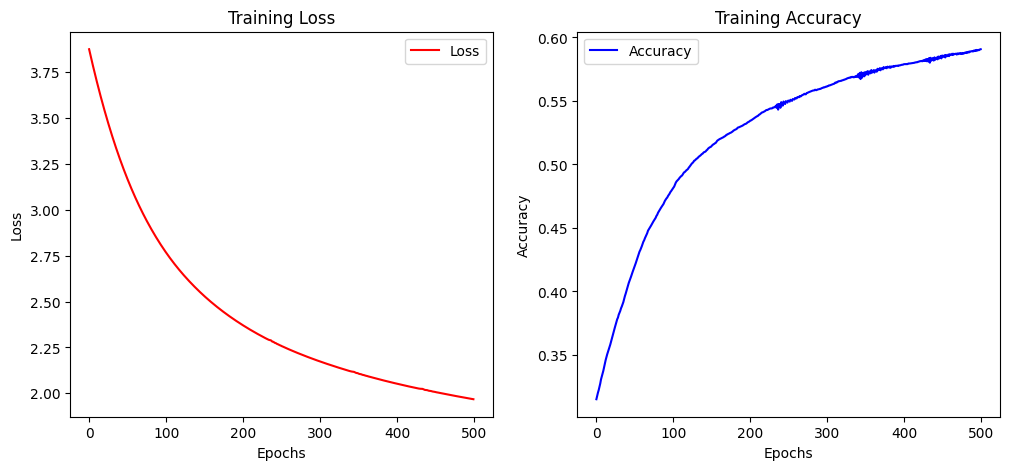

In [19]:
# Plot Loss and Accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.show()

In [20]:
# Generate text
def generate_text(start_word, length=5):
    model.eval()
    words = [start_word]
    for _ in range(length):
        input_seq = torch.tensor([one_hot_encode(words[-1], vocab_size)], dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            output = model(input_seq)
            next_word = idx_to_word[torch.argmax(output).item()]
        words.append(next_word)
    return ' '.join(words)

print("Generated Text:", generate_text("love"))


Generated Text: love show up up up up
